In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [4]:
import numpy as np
import pandas as pd

import cortex

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.utils import get_surface_dict, put_values_on_mask, two_side_ks_test, timescale_permutation_test
from src.utils.meta import read_result_meta
from src.utils.plot import plot_flatmap_from_vertex, config_plotting
from src.configurations import timescale_ranges

from src.utils.plot import figsize_dict

from voxelwise_tutorials.io import load_hdf5_sparse_array

from cortex.quickflat import make_figure

In [5]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

mapper_dir = "/mnt/raid/bling/share/mappers"

result_metric = "r2"
result_meta_dir = ".temp/result_meta/bling"

subjects_ids = ["COL", "GFW", "TYE"]
languages = ["en", "zh"]

fsaverage_surface = "fsaverage"

yeos_label_dir = ".temp/misc/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label"

alpha = 0.05
alpha_pred_acc = None

plotting_context = "paper"
figsize_type = 'full'

analysis_name = "timescale_selectivity_yeos"


In [6]:

config_plotting(context=plotting_context)

figsize = figsize_dict[figsize_type]

In [7]:
timescale_data = {}
prediction_acc_data = {}

for subject_id in subjects_ids:
    surface_dict = get_surface_dict(subject_id)

    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    mapper_file = os.path.join(mapper_dir, f"{subject_id}_fsaverage_mapper.hdf")

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )

    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stats = np.load(en_config["stats_path"])
    zh_stats = np.load(zh_config["stats_path"])

    keyword = f"test_{result_metric}_selectivity_mask"
    pred_acc_keyword = f"test_joint_{result_metric}_score_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    timescale_en, _ = put_values_on_mask(
        en_stats[keyword],
        en_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(8, 256),
    )

    timescale_zh, _ = put_values_on_mask(
        zh_stats[keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(8, 256),
    )
    
    if result_metric == "r2":
        en_pred = np.maximum(0, np.sqrt(en_stats[pred_acc_keyword]))
        zh_pred = np.maximum(0, np.sqrt(zh_stats[pred_acc_keyword]))
            
    pred_acc_en, _ = put_values_on_mask(
        en_pred,
        en_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(0,1),
    )
    
    pred_acc_zh, _ = put_values_on_mask(    
        zh_pred,
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(0,1),
    )

    # project to fsaverage
    mapper = load_hdf5_sparse_array(mapper_file, key="voxel_to_fsaverage")

    projected_en = timescale_en @ mapper.T
    projected_zh = timescale_zh @ mapper.T
    
    projected_pred_acc_en = pred_acc_en @ mapper.T
    projected_pred_acc_zh = pred_acc_zh @ mapper.T

    # drop nan
    timescale_data[subject_id] = {
        "en": projected_en,
        "zh": projected_zh,
    }
    
    prediction_acc_data[subject_id] = {
        "en": projected_pred_acc_en,
        "zh": projected_pred_acc_zh,
    }

/tmp/ipykernel_1713049/208903833.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.maximum(0, np.sqrt(en_stats[pred_acc_keyword]))
/tmp/ipykernel_1713049/208903833.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.maximum(0, np.sqrt(zh_stats[pred_acc_keyword]))
/tmp/ipykernel_1713049/208903833.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.maximum(0, np.sqrt(en_stats[pred_acc_keyword]))
/tmp/ipykernel_1713049/208903833.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.maximum(0, np.sqrt(zh_stats[pred_acc_keyword]))
/tmp/ipykernel_1713049/208903833.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.maximum(0, np.sqrt(en_stats[pred_acc_keyword]))
/tmp/ipykernel_1713049/208903833.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.maximum(0, np.sqrt(zh_stats[pred_acc_keyword]))


Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: COL, lang: en


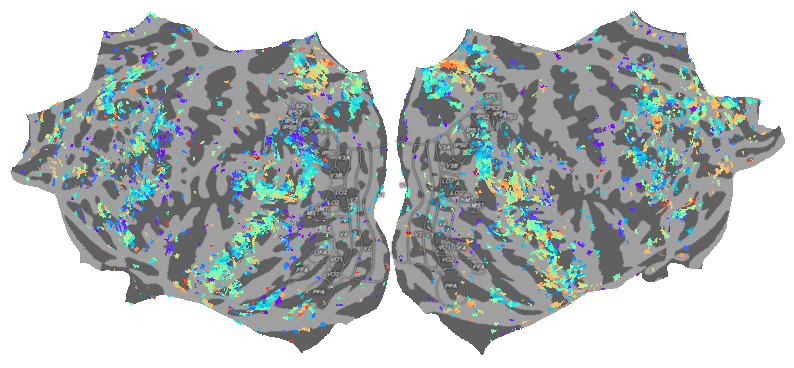

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: COL, lang: zh


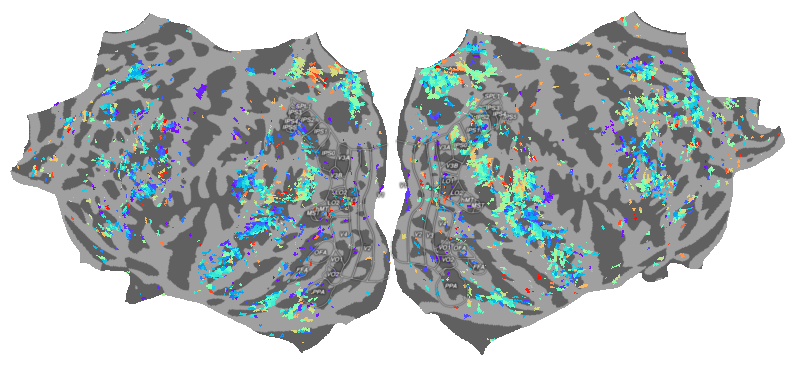

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: COL, lang: diff


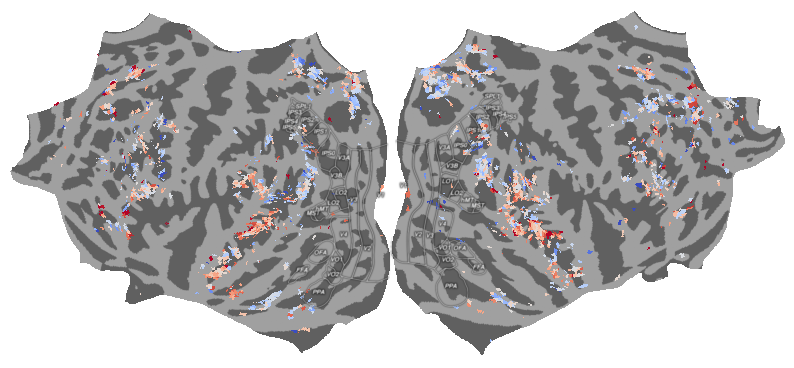

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: GFW, lang: en


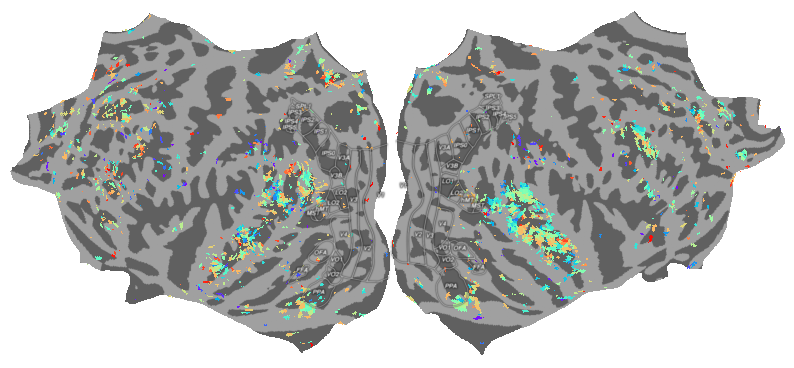

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: GFW, lang: zh


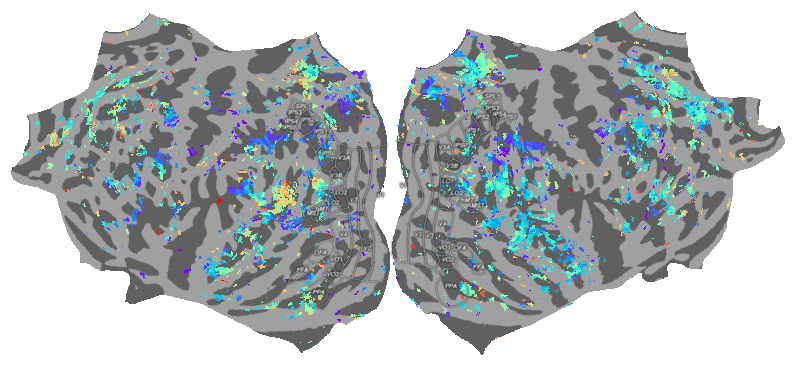

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: GFW, lang: diff


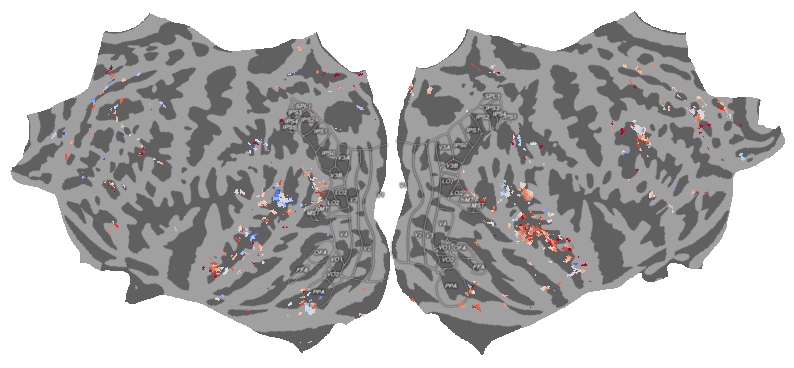

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: TYE, lang: en


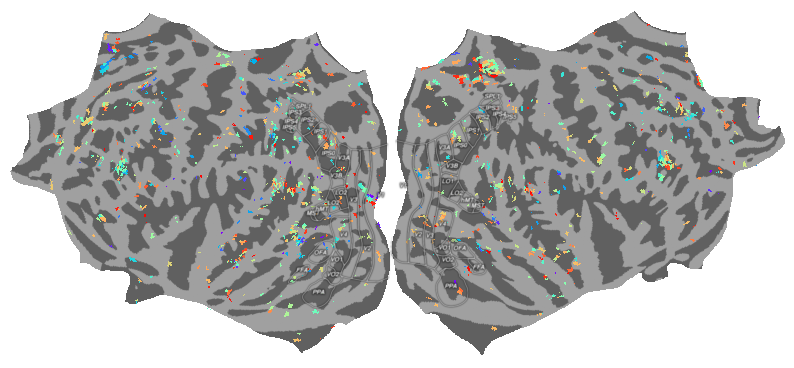

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: TYE, lang: zh


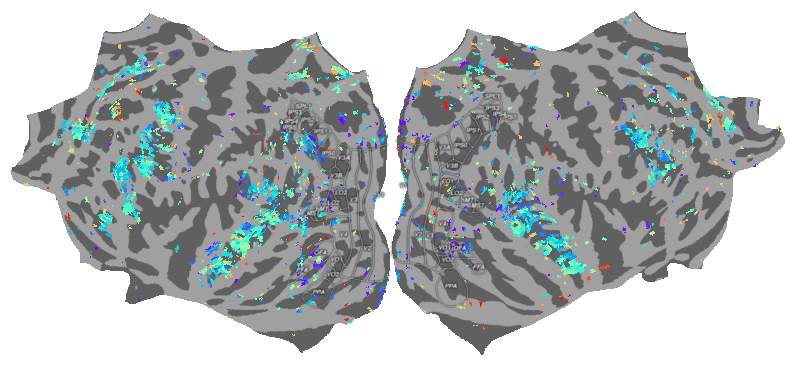

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)
subject: TYE, lang: diff


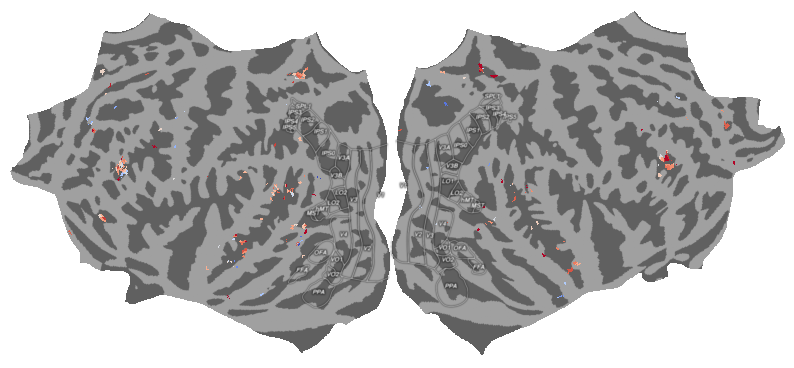

In [13]:
for subject_id in subjects_ids:

    lang = "en"
    data_en = timescale_data[subject_id][lang]
    data_en = np.where((data_en >= 8) & (data_en <= 256), data_en, np.nan)

    en_vertex = cortex.Vertex(data_en, fsaverage_surface, vmin=8, vmax=256, cmap="rainbow",)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    make_figure(
        en_vertex,
        fig=ax,
        with_colorbar=False,
        with_curvature=True,
        nanmean=True,
        ax=ax,
    )
    
    print(f"subject: {subject_id}, lang: {lang}")
    save_path=f".temp/image/{analysis_name}/{subject_id}/{lang}_flatmap.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True) 
    plt.savefig(save_path, dpi=300)
    plt.show()

    lang="zh"
    data_zh = timescale_data[subject_id][lang]
    data_zh = np.where((data_zh >= 8) & (data_zh <= 256), data_zh, np.nan)

    zh_vertex = cortex.Vertex(data_zh, fsaverage_surface, vmin=8, vmax=256, cmap="rainbow",)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    make_figure(
        zh_vertex,
        fig=ax,
        with_colorbar=False,
        with_curvature=True,
        nanmean=True,
        ax=ax,
    )
    
    print(f"subject: {subject_id}, lang: {lang}")
    save_path=f".temp/image/{analysis_name}/{subject_id}/{lang}_flatmap.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True) 
    plt.savefig(save_path, dpi=300)
    plt.show()
    
    
    data_diff = data_en - data_zh
    
    diff_vertex = cortex.Vertex(data_diff, fsaverage_surface, vmin=-128, vmax=128, cmap="coolwarm",)    
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    make_figure(
        diff_vertex,
        fig=ax,
        with_colorbar=False,
        with_curvature=True,
        nanmean=True,
        ax=ax,
    )
    
    print(f"subject: {subject_id}, lang: diff")
    save_path=f".temp/image/{analysis_name}/{subject_id}/diff_flatmap.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()